In [7]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import mujoco
from mujoco import mjx
import jax
import pickle
import numpy as np
from dm_control import mjcf
from dm_control.locomotion.walkers import rescale
import utils
import controller as ctrl
import operations as op
from jax import numpy as jnp
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

model_xml = "../models/rodent_stac_optimized.xml"
params_path = "../params/params.yaml"
utils.init_params(params_path)

data_path = "../transform_random_1k_12_21_1.p"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### set up mj model -- stepping in mujoco and not mjx so it's easier to update mjcf--the physics should be similar

In [8]:
# Load mjx_model and mjx_data and set marker sites
root = mjcf.from_path(model_xml)
physics, mj_model = ctrl.create_body_sites(root)
# physics, mj_model, keypoint_sites = ctrl.create_keypoint_sites(root)

rescale.rescale_subtree(
    root,
    utils.params["SCALE_FACTOR"],
    utils.params["SCALE_FACTOR"],
)

# Load data
with open(data_path, "rb") as file:
    d = pickle.load(file)
    qposes = np.array(d["qpos"])
    kp_data = np.array(d["kp_data"])
    offsets = np.array(d['offsets'])

# slice kp_data to match qposes length
kp_data = kp_data[:qposes.shape[0]]

In [9]:
def resid(mjx_model, mjx_data, qpos, kps):
    mjx_data = mjx_data.replace(qpos=qpos)
    # Forward kinematics
    mjx_data = op.kinematics(mjx_model, mjx_data)
    mjx_data = op.com_pos(mjx_model, mjx_data)
    # get marker positions
    markers = op.get_site_xpos(mjx_data).flatten()
    # Return the summed squared error
    return jnp.sum(jnp.square((kps - markers)))

In [10]:
@jax.vmap
def batch_init(batch_qposes):
    mjx_model = mjx.put_model(mj_model)
    mjx_model = op.set_site_pos(mjx_model, jnp.reshape(offsets, (-1, 3))) 
    mjx_data = mjx.make_data(mjx_model)
    return mjx_model, mjx_data

In [11]:
# reshape qposes and kp_data such that it is shape: (n, b, x)
# n = iterations, b = batchsize, x = dims of the data
batch_qposes = qposes.reshape(1000,360,74)
batch_kps = kp_data.reshape(1000,360,69)

batch_qposes.shape, batch_kps.shape

((1000, 360, 74), (1000, 360, 69))

In [12]:
mjx_model, mjx_data = batch_init(batch_qposes)
jit_vmap_resid = jax.jit(jax.vmap(resid))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350


In [41]:
errors = []
# render while stepping using mujoco
for i in range(360):
    if i%50 == 0:
        print(f"{i}")
    qpos = batch_qposes[:, i, :]
    kps = batch_kps[:, i, :]
    # Calculate squared error btwn offsets and keypoints
    errors.append(jit_vmap_resid(mjx_model, mjx_data, qpos, kps))

errors = np.array(errors)
errors = errors.ravel(order="F")

0
50
100
150
200
250
300
350


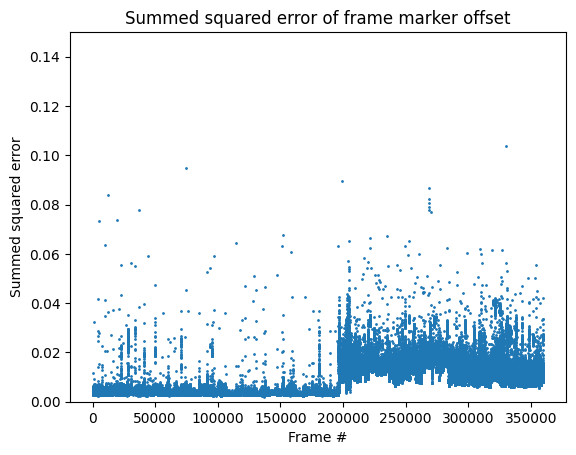

In [42]:
plt.ylim(0, 0.15)
plt.title("Summed squared error of frame marker offset")
plt.xlabel("Frame #")
plt.ylabel("Summed squared error")
x = 360000
plt.scatter(np.arange(x),errors[:x], s=1)

In [43]:
# Save it as .npy file
np.save("../offset_errors/errors_" + data_path[3:-2] + ".npy", errors)


In [79]:
errors[:190000].mean(), errors[:190000].std()

(0.0036285082, 0.0014648745)

In [102]:
cutoff = 190000
indices = np.where(errors[:cutoff] > 0.01)[0]

print(f"there are {indices.shape[0]} not good offset frames before the cutoff at {cutoff}")

there are 611 not good offset frames before the cutoff at 190000


(array([0.00000e+00, 0.00000e+00, 2.00000e+00, 2.10010e+04, 1.16454e+05,
        3.99920e+04, 7.79400e+03, 2.54900e+03, 1.04500e+03, 2.98000e+02,
        1.14000e+02, 8.10000e+01, 4.70000e+01, 3.40000e+01, 3.50000e+01,
        2.90000e+01, 1.70000e+01, 2.80000e+01, 2.80000e+01, 2.30000e+01,
        1.70000e+01, 9.00000e+00, 8.00000e+00, 7.00000e+00, 3.20000e+01,
        2.00000e+01, 2.40000e+01, 2.30000e+01, 2.00000e+01, 3.50000e+01,
        2.20000e+01, 1.40000e+01, 1.40000e+01, 1.90000e+01, 2.70000e+01,
        1.60000e+01, 1.00000e+01, 2.10000e+01, 1.80000e+01, 8.00000e+00,
        3.00000e+00, 3.00000e+00, 4.00000e+00, 2.00000e+00, 3.00000e+00,
        2.00000e+00, 2.00000e+00, 2.00000e+00, 5.00000e+00, 6.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00,
        1.00000e+00, 2.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00

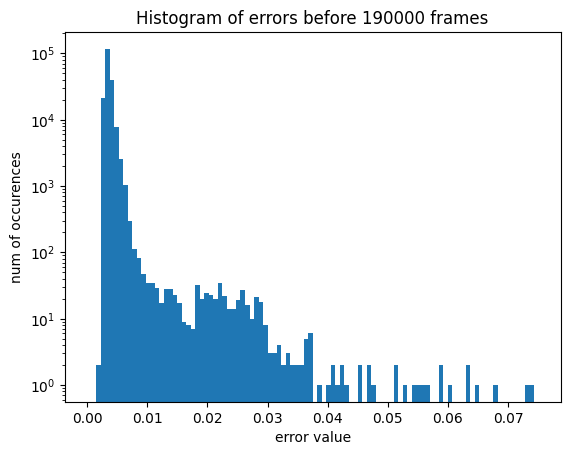

In [101]:
# plot graph where x = error value and y = number of frames in log scale
plt.title(f"Histogram of errors before {cutoff} frames")
plt.xlabel("error value")
plt.ylabel("num of occurences")
plt.hist(errors[:cutoff], bins=100, range=(0,0.075), log=True)


In [75]:
indices[:100]

array([    0,  1258,  1440,  3960,  3961,  3962,  3963,  3964,  3965,
        5040,  5041,  5042,  7560,  7561,  7562,  7563,  7564,  7565,
        7566, 10080, 10081, 10082, 10083, 10084, 10887, 11741, 12600,
       12601, 12602, 14400, 14401, 16560, 16561, 16562, 16563, 17280,
       18360, 19800, 19801, 19802, 19803, 19804, 20880, 20881, 20882,
       20883, 20884, 21600, 22680, 22681, 23040, 23041, 23042, 23043,
       23044, 23045, 23046, 23047, 23048, 23049, 23050, 23051, 23052,
       23053, 23054, 23055, 23056, 23057, 23058, 23059, 23060, 23061,
       23062, 23063, 23064, 23065, 23066, 23067, 23068, 23069, 23070,
       23071, 23072, 23073, 23074, 23075, 23076, 23077, 23078, 23079,
       23080, 23081, 23082, 23083, 23084, 23085, 23086, 23087, 23091,
       24380])

# view select frame where we have high error

In [66]:
import mediapy as media
from dm_control.mujoco.wrapper.mjbindings import enums
root = mjcf.from_path(model_xml)
physics, mj_model = ctrl.create_body_sites(root)
physics, mj_model, keypoint_sites = ctrl.create_keypoint_sites(root)
renderer = mujoco.Renderer(mj_model)
mj_data = mujoco.MjData(mj_model)
scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = 1
scene_option.sitegroup[2] = 1

scene_option.sitegroup[3] = 1
scene_option.flags[enums.mjtVisFlag.mjVIS_TRANSPARENT] = True
scene_option.flags[enums.mjtVisFlag.mjVIS_LIGHT] = False
scene_option.flags[enums.mjtVisFlag.mjVIS_CONVEXHULL] = True
scene_option.flags[enums.mjtRndFlag.mjRND_SHADOW] = False
scene_option.flags[enums.mjtRndFlag.mjRND_REFLECTION] = False
scene_option.flags[enums.mjtRndFlag.mjRND_SKYBOX] = False
scene_option.flags[enums.mjtRndFlag.mjRND_FOG] = False

""

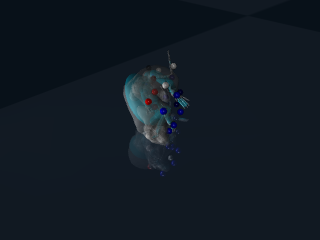

In [78]:
index = 7560
mj_data.qpos = qposes[index]
physics, mj_model = ctrl.set_keypoint_sites(physics, keypoint_sites, kp_data[index])
mujoco.mj_forward(mj_model, mj_data)
renderer.update_scene(mj_data, camera="close_profile", scene_option=scene_option)

media.show_image(renderer.render())